In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn.functional as F
torch.cuda.set_device(1)
import models, train, utils
from importlib import reload
reload(models)
reload(train)
reload(utils)

<module 'utils' from '/home/cse/btech/cs1180416/col870-deep-learning/A2/utils.py'>

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
query_X = torch.load('data/pt-cache/query_X.pt', map_location='cpu')
target_X = torch.load('data/pt-cache/target_X.pt', map_location='cpu')
query_y = torch.load('data/pt-cache/query_y.pt', map_location='cpu')
target_y = torch.load('data/pt-cache/target_y.pt', map_location='cpu')

In [4]:
train_X, test_X = torch.split(query_X, [9000,1000], dim=0)
train_Y, test_Y = torch.split(target_X, [9000,1000], dim=0)

In [5]:
test_x = query_y[-64000:]
test_y = target_y[-64000:]

In [6]:
samples = (torch.tensor(np.load('data/sample_images.npy')).float()/127.5-1)[:9,None,:,:]

In [7]:
net = models.LeNetRRN(24, 1, samples)

In [8]:
net.lenet.load_state_dict(torch.load('data/pt-cache/lenet.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
net.rrn.load_state_dict(torch.load('data/pt-cache/rrn_24.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

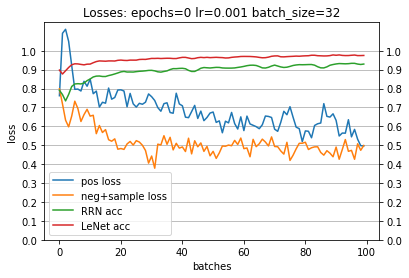

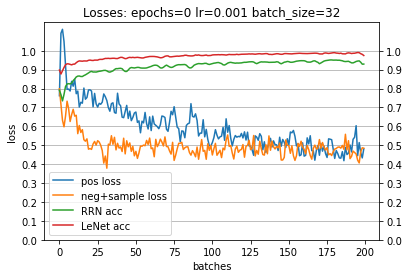

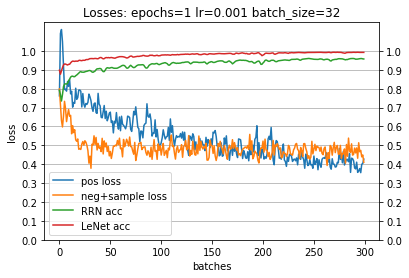

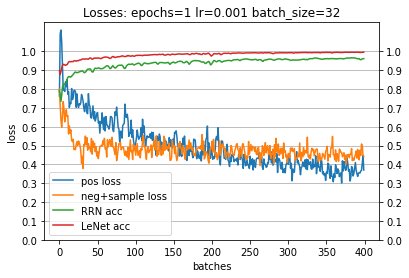

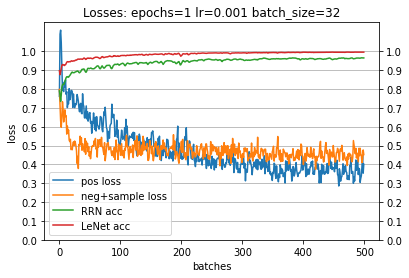

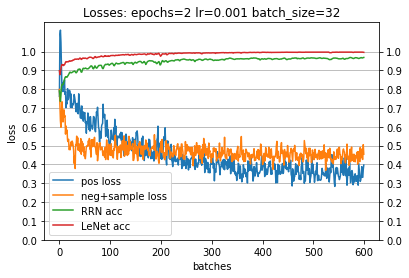

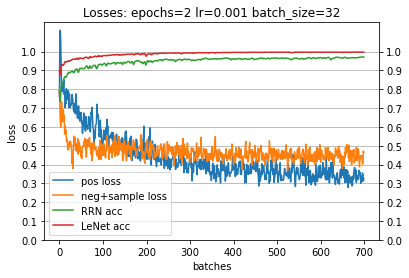

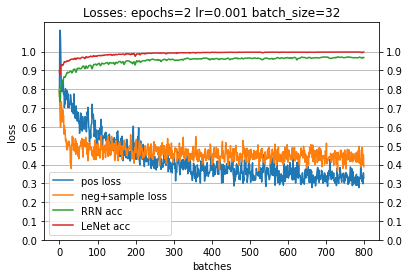

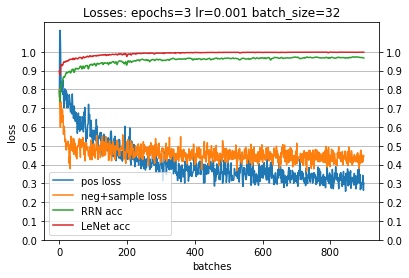

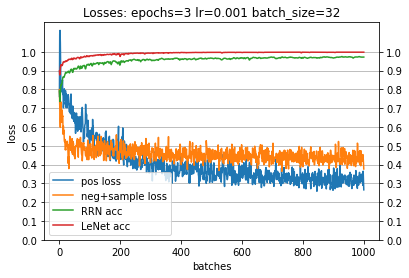

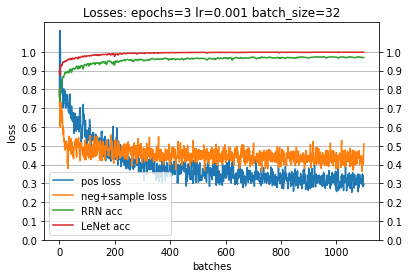

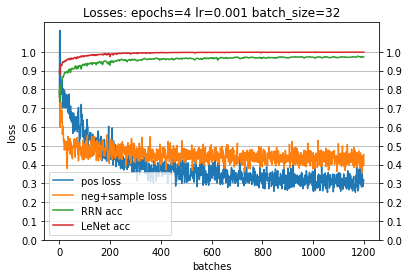

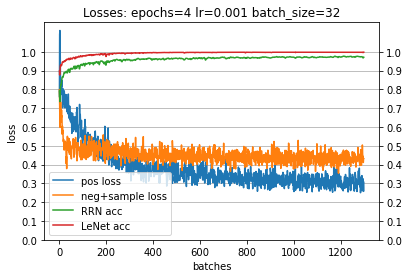

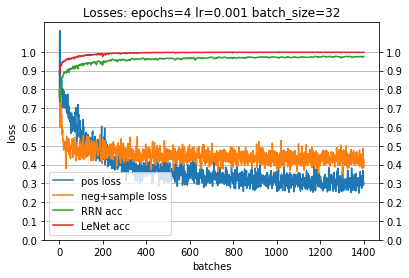

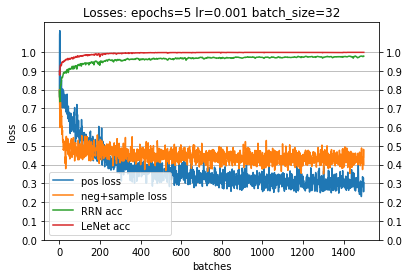

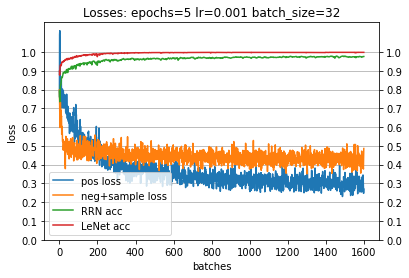

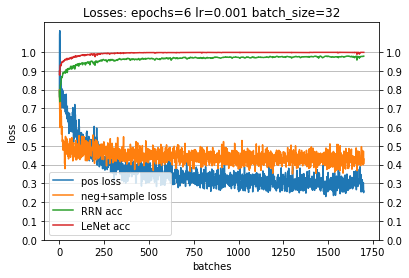

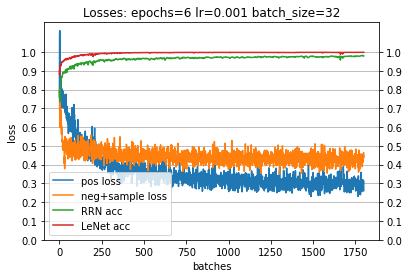

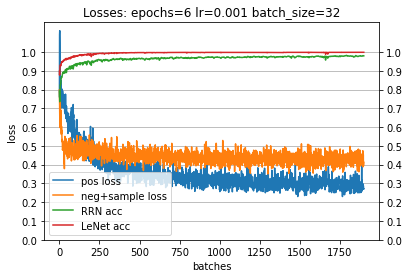

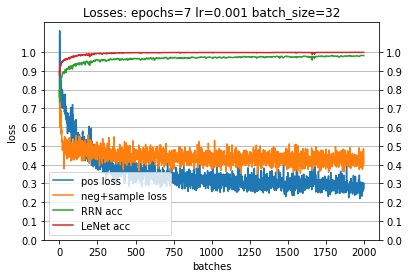

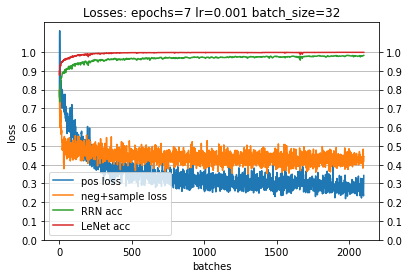

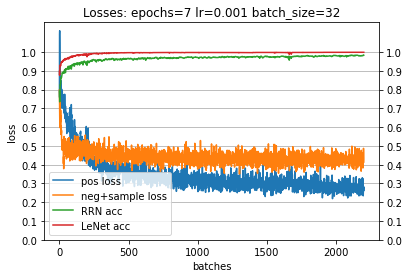

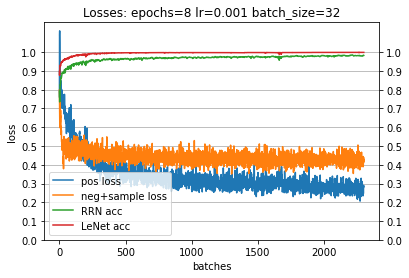

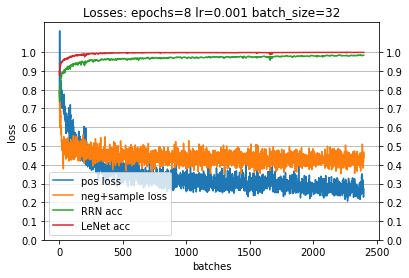

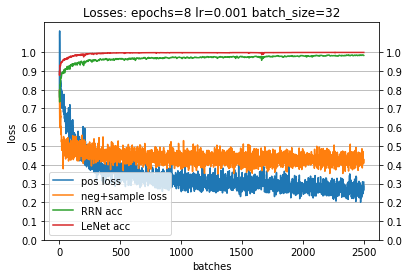

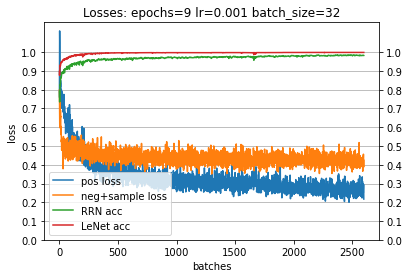

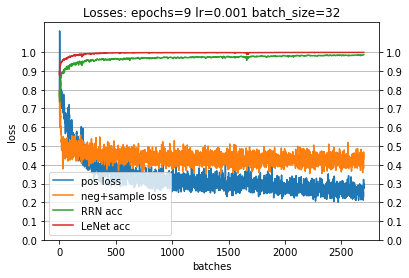

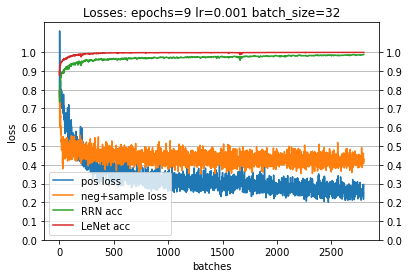

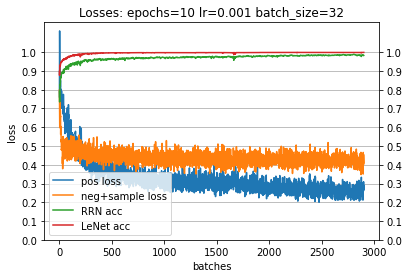

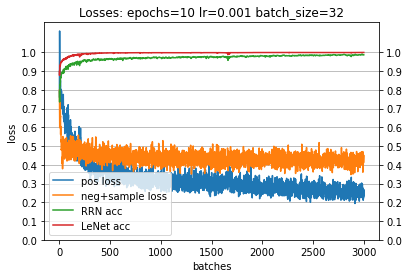

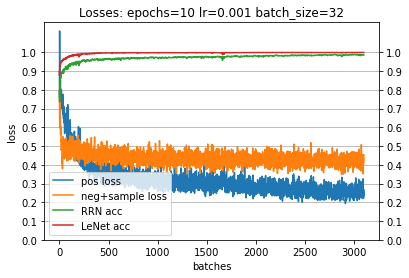

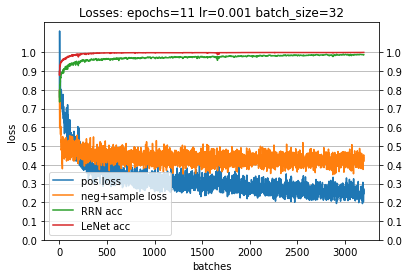

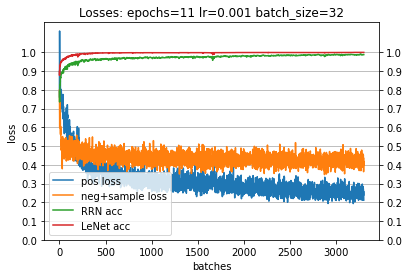

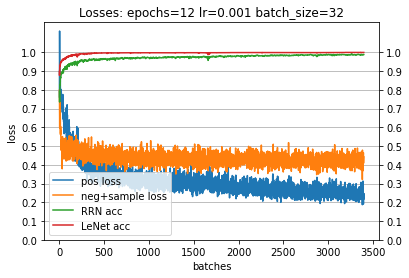

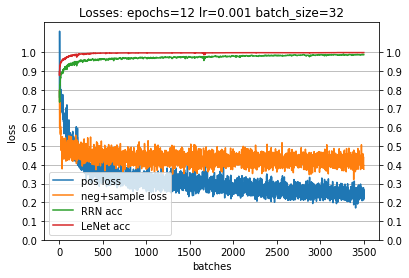

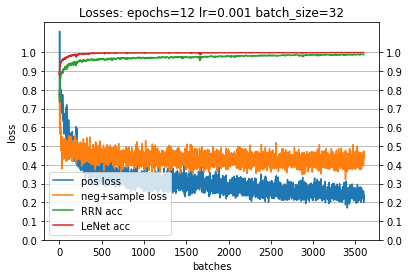

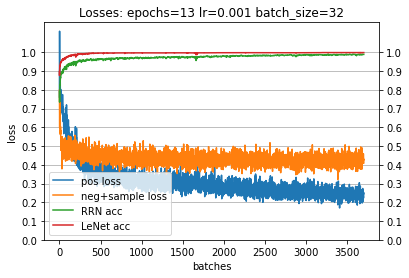

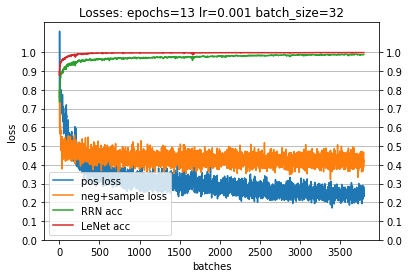

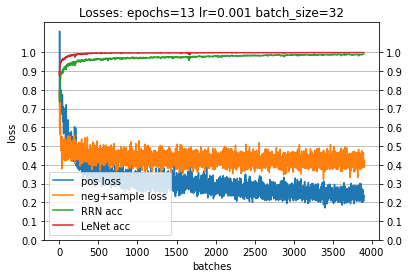

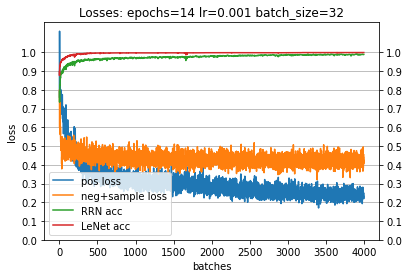

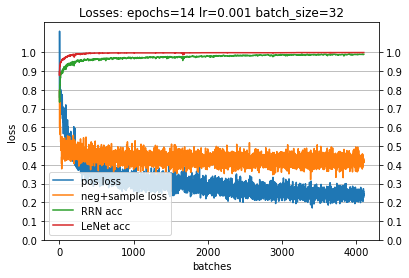

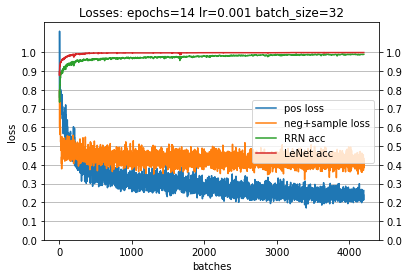

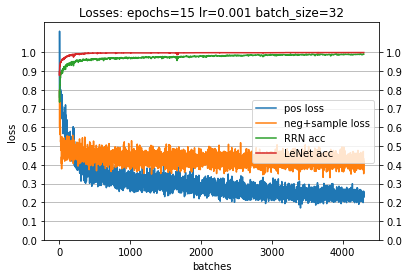

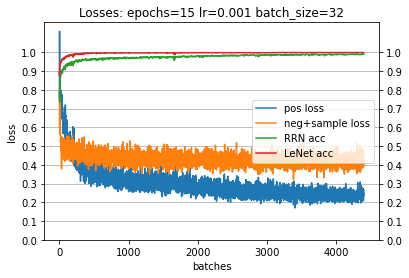

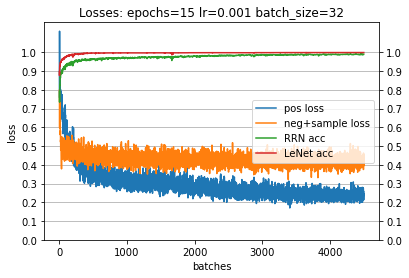

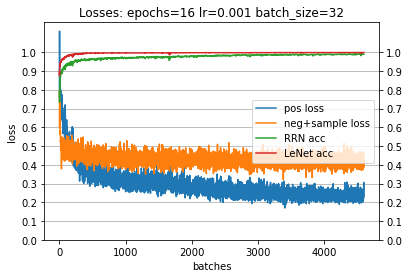

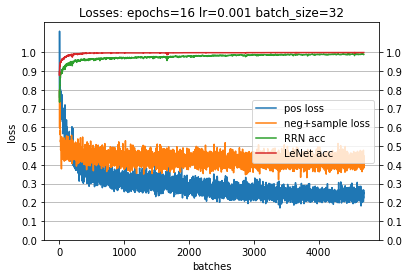

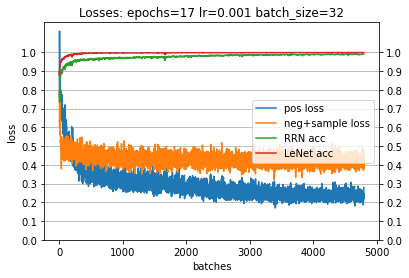

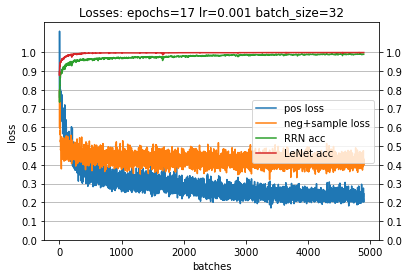

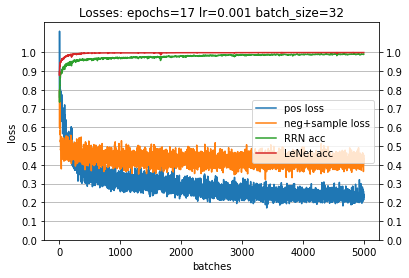

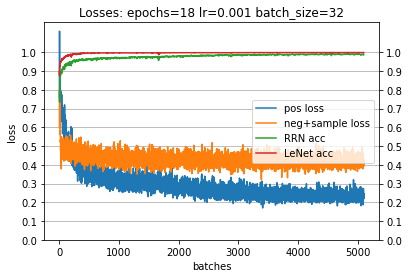

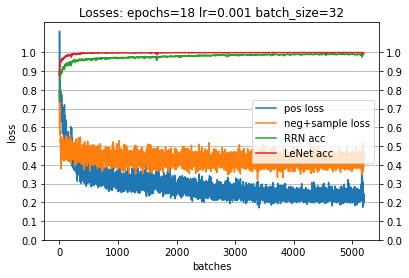

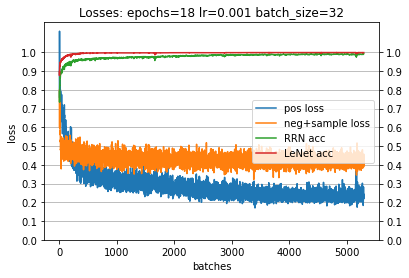

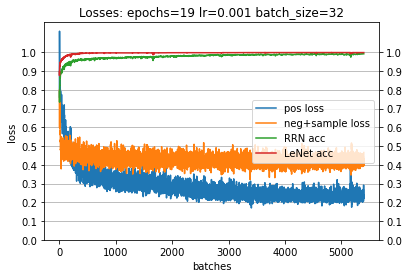

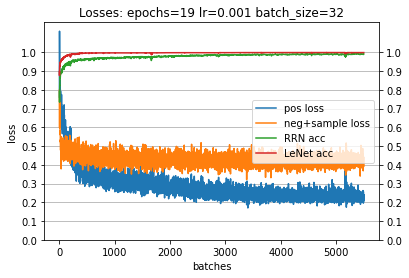

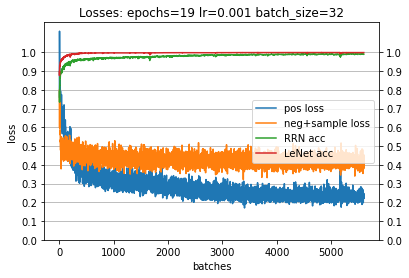

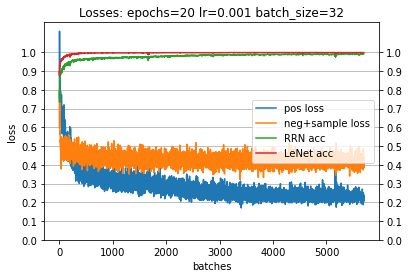

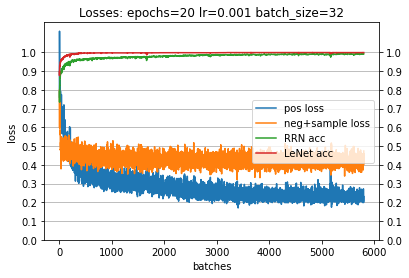

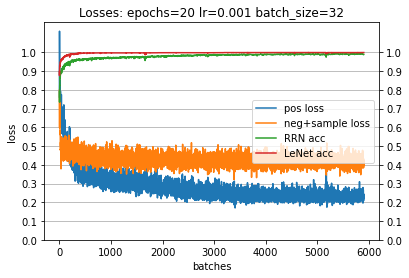

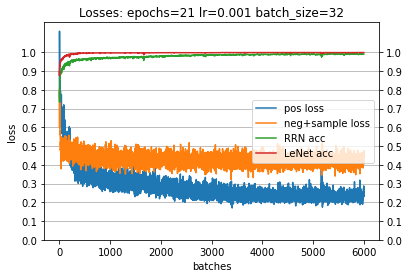

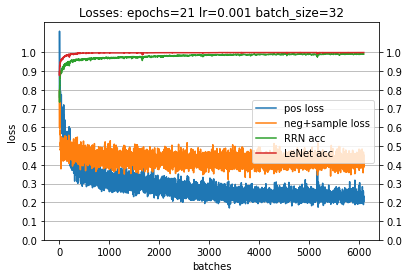

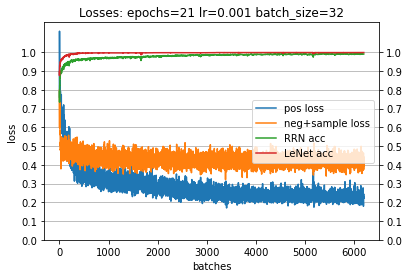

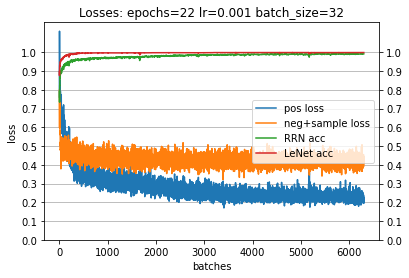

KeyboardInterrupt: 

In [17]:
train.train_lenet_rrn(net, train_X, train_Y, test_X, test_Y, test_x, test_y,
                      lr=1e-3, batch_size=32, n_epochs=1000, device=device,
                      show_step=100)

In [18]:
# torch.save(net.state_dict(), 'data/pt-cache/lenet_rrn_w1.pt')

In [8]:
net.load_state_dict(torch.load('data/pt-cache/lenet_rrn_w1.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
net = net.to(device)

In [10]:
with torch.no_grad():
    test_pred = torch.cat([net.predict(test_X[i*100:(i+1)*100].to(device)).cpu() for i in range(10)])

In [11]:
utils.validate_sudokus(test_y, test_pred)

digit level accuracy: 0.992578125
number of sudokus correctly solved: 925 / 1000


In [14]:
with torch.no_grad():
    test_pred = torch.cat([net.rrn.predict(F.one_hot(test_x[i*6400:(i+1)*6400].long().to(device), num_classes=9)).cpu() for i in range(10)])

In [15]:
utils.validate_sudokus(test_y, test_pred)

digit level accuracy: 0.99303125
number of sudokus correctly solved: 939 / 1000


In [16]:
print(classification_report(test_x, net.lenet.predict(utils.split_sudoku_img(test_X.to(device))).cpu()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31495
           1       1.00      1.00      1.00      4088
           2       1.00      1.00      1.00      4069
           3       1.00      1.00      1.00      4028
           4       1.00      1.00      1.00      4014
           5       1.00      0.99      1.00      4026
           6       1.00      1.00      1.00      4120
           7       1.00      1.00      1.00      4115
           8       1.00      1.00      1.00      4045

    accuracy                           1.00     64000
   macro avg       1.00      1.00      1.00     64000
weighted avg       1.00      1.00      1.00     64000



In [82]:
torch.cuda.empty_cache()